In [1]:
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder \
    .appName("part2") \
    .getOrCreate()

24/05/13 17:36:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
#load form GCS
gcs_path = "gs://228bucket/processed_train_2.0.csv/processed_dataset_2.0.csv"

# read CSV file
df = spark.read.format("csv") \
        .option("header", "true") \
        .option("inferSchema", "true") \
        .load(gcs_path)

df.show(2)

# Show the DataFrame schema to verify data types
df.printSchema()


+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
only showing top 2 rows

root
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: do

In [3]:
# Collect a sample of the data
pickup_sample = df.select("pickup_latitude", "pickup_longitude").sample(fraction=0.01, withReplacement=False).toPandas()
dropoff_sample = df.select("dropoff_latitude", "dropoff_longitude").sample(fraction=0.01, withReplacement=False).toPandas()


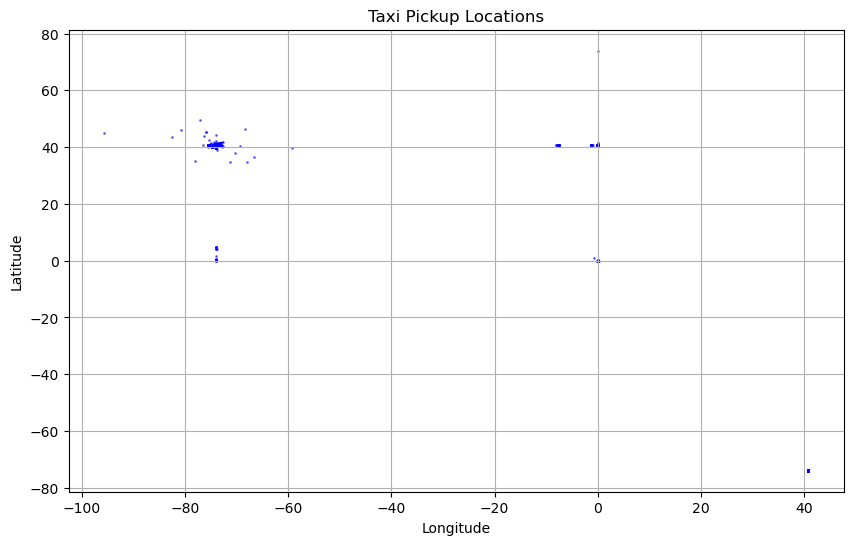

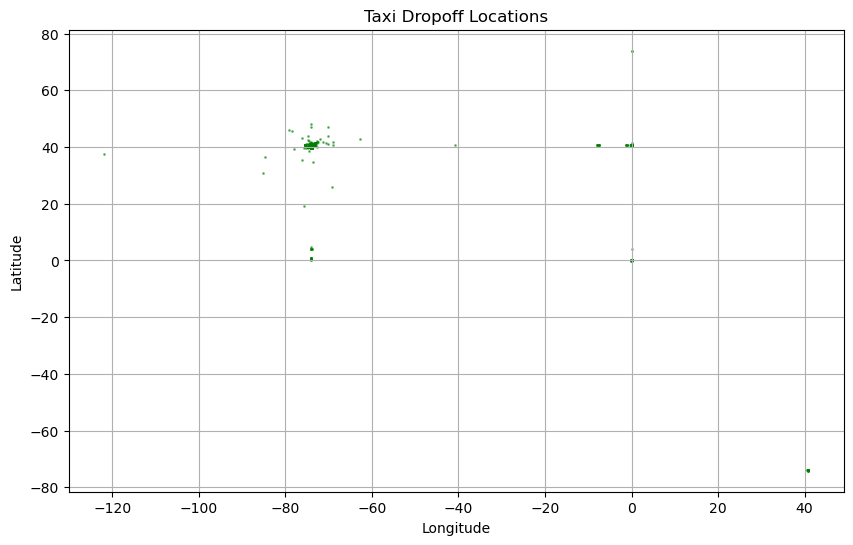

In [4]:
import matplotlib.pyplot as plt

def plot_geo_points(df, title, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['longitude'], df['latitude'], color=color, alpha=0.5, s=1)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

# Plot for pickup points
plot_geo_points(pickup_sample.rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude': 'latitude'}),
                'Taxi Pickup Locations', 'blue')

# Plot for dropoff points
plot_geo_points(dropoff_sample.rename(columns={'dropoff_longitude': 'longitude', 'dropoff_latitude': 'latitude'}),
                'Taxi Dropoff Locations', 'green')

plt.show()


# Query 1: Average fare amount by passenger count

In [6]:
# Register the DataFrame as a temp view so we can query it using SQL
df.createOrReplaceTempView("taxi_rides")

In [7]:
spark.sql("""
SELECT passenger_count, AVG(fare_amount) AS avg_fare
FROM taxi_rides
GROUP BY passenger_count
ORDER BY passenger_count
""").show()

+---------------+------------------+
|passenger_count|          avg_fare|
+---------------+------------------+
|              1|11.318552114654471|
|              2|11.959652118520198|
|              3|11.660967672798673|
|              4|11.883823626135108|
|              5|11.360065294555547|
|              6|12.108472345618125|
|              7|            37.783|
|              8|          32.72875|
|              9| 34.64470588235294|
|             34|              13.3|
|             49|               2.5|
|            129|               8.5|
|            208|12.284210526315789|
+---------------+------------------+



# Query 2: Count of rides by hour of day

In [9]:
from pyspark.sql.functions import hour

# Add hour of day column
df1 = df.withColumn("pickup_hour", hour(df["pickup_datetime"]))

# Register the modified DataFrame as a view
df1.createOrReplaceTempView("taxi_rides")

# SQL query
spark.sql("""
SELECT pickup_hour, COUNT(*) AS count_rides
FROM taxi_rides
GROUP BY pickup_hour
ORDER BY pickup_hour
""").show()


+-----------+-----------+
|pickup_hour|count_rides|
+-----------+-----------+
|          0|    1704355|
|          1|    1264099|
|          2|     943332|
|          3|     690209|
|          4|     499705|
|          5|     421448|
|          6|     884136|
|          7|    1547067|
|          8|    1936864|
|          9|    2000093|
|         10|    1938252|
|         11|    1999435|
|         12|    2108492|
|         13|    2093709|
|         14|    2156861|
|         15|    2047892|
|         16|    1743203|
|         17|    2102028|
|         18|    2568391|
|         19|    2673494|
+-----------+-----------+
only showing top 20 rows



# Query 3: Distribution of fare amounts

In [10]:
spark.sql("""
SELECT fare_amount, COUNT(*) AS count
FROM taxi_rides
GROUP BY fare_amount
ORDER BY fare_amount DESC
""").show()


+-----------+-----+
|fare_amount|count|
+-----------+-----+
|     1564.5|    1|
|     1021.3|    1|
|      900.0|    1|
|      668.5|    1|
|     651.07|    1|
|     586.84|    1|
|     544.44|    1|
|      532.5|    1|
|      500.0|   12|
|     499.99|    1|
|      499.0|    7|
|     498.65|    1|
|      495.0|    1|
|      488.0|    1|
|      480.0|    1|
|     479.35|    1|
|     477.97|    1|
|     477.92|    1|
|      476.1|    1|
|      475.0|    5|
+-----------+-----+
only showing top 20 rows



# Distance of Rides

In [11]:
from pyspark.sql.functions import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Add distance column
df1 = df1.withColumn("distance", haversine(df1.pickup_longitude, df1.pickup_latitude, df1.dropoff_longitude, df1.dropoff_latitude))
df1.createOrReplaceTempView("taxi_rides")


# Query Distance vs. Fare

In [12]:
spark.sql("""
SELECT distance, AVG(fare_amount) AS avg_fare
FROM taxi_rides
GROUP BY distance
ORDER BY distance
""").show()


+--------------------+------------------+
|            distance|          avg_fare|
+--------------------+------------------+
|                 0.0|11.563690319557326|
|8.374409438360923E-5|             100.0|
|8.375477495921987E-5|             160.5|
|8.375559193483956E-5|             127.0|
|8.381757987256205E-5|               2.5|
|8.385949715296521E-5|             186.0|
|8.386963428034234E-5|            116.44|
|8.387686046103143E-5|            230.08|
|  8.3900142707052E-5|             150.0|
|8.390277395424866E-5|              80.0|
|8.391638694176093E-5|              45.0|
|8.393476811512889E-5|             100.0|
|8.395739649710186E-5|              64.0|
|8.395803166156986E-5|             114.0|
|8.397133127600444E-5|             113.5|
|8.397860906458268E-5|             120.0|
|8.399634249941402E-5|              15.0|
| 8.39971563747577E-5|              95.0|
|8.399894432035044E-5|              92.0|
|8.400384267544314E-5|              88.0|
+--------------------+------------

# Feature Engineering

In [13]:
from pyspark.sql.functions import hour, dayofweek, month

df1 = df1.withColumn("pickup_hour", hour("pickup_datetime"))
df1 = df1.withColumn("day_of_week", dayofweek("pickup_datetime"))
df1 = df1.withColumn("month", month("pickup_datetime"))


# Haversine Distance:
We'll use the previously defined haversine function to calculate the distance between pickup and dropoff points.


In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Register UDF
haversine_udf = udf(haversine, DoubleType())
df1 = df1.withColumn("distance", haversine_udf("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"))


# Data Exploration and Insights
## Average fare by hour of day:
This could show if fares are higher at certain times of the day, potentially during rush hours.

In [15]:
df1.groupBy("pickup_hour").avg("fare_amount").orderBy("pickup_hour").show()


+-----------+------------------+
|pickup_hour|  avg(fare_amount)|
+-----------+------------------+
|          0|11.801578157132615|
|          1|11.534434304591603|
|          2|11.502305614566241|
|          3|11.975403711049816|
|          4| 13.78769926256482|
|          5|15.421085804179638|
|          6|12.272836599799126|
|          7| 11.11495076166687|
|          8|11.052514538965829|
|          9|10.990217259897168|
|         10|11.045287021501592|
|         11|11.237934461485104|
|         12| 11.25240026047023|
|         13|11.667852103611052|
|         14| 12.02600280685669|
|         15| 12.12672119428147|
|         16|12.041900404026087|
|         17|11.645416031565427|
|         18|11.045682483702862|
|         19|10.665419727891683|
+-----------+------------------+
only showing top 20 rows



# Average fare by day of the week:
To analyze if weekend trips are more expensive.

In [16]:
df1.groupBy("day_of_week").avg("fare_amount").orderBy("day_of_week").show()


+-----------+------------------+
|day_of_week|  avg(fare_amount)|
+-----------+------------------+
|          1|11.746857809813179|
|          2|11.496004223683046|
|          3| 11.30810133086045|
|          4|11.430351493175094|
|          5|11.632963298204645|
|          6|11.545678391899033|
|          7|11.096751985965502|
+-----------+------------------+



# Visualizing Data

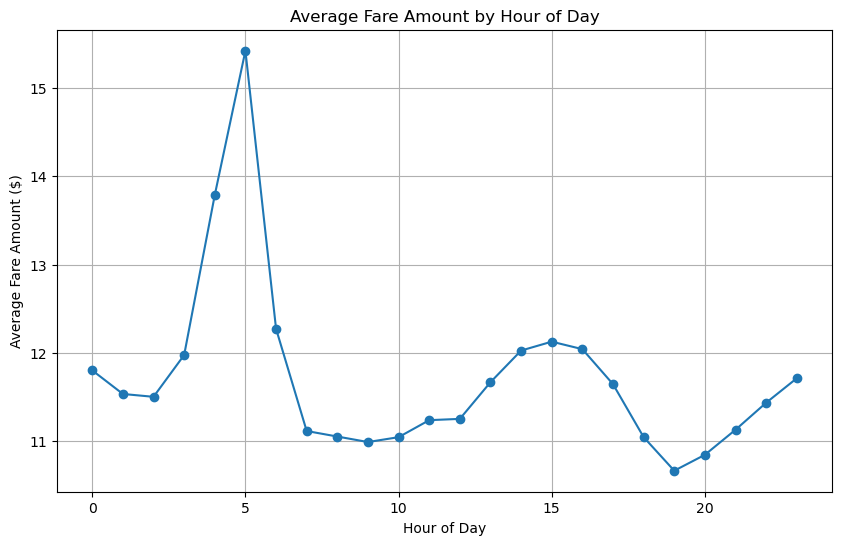

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


result_pd = df1.groupBy("pickup_hour").avg("fare_amount").orderBy("pickup_hour").toPandas()

plt.figure(figsize=(10, 6))
plt.plot(result_pd["pickup_hour"], result_pd["avg(fare_amount)"], marker='o')
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fare Amount ($)')
plt.grid(True)
plt.show()


# Aggregation by Dropoff Location
## Average fare and ride counts by dropoff zone:
Assuming you have zones or can create them from coordinates.

In [18]:
from pyspark.sql.functions import round

# Correct the rounding operation for the dropoff latitude and longitude zones
df1 = df1.withColumn("dropoff_lat_zone", round(df1.dropoff_latitude))
df1 = df1.withColumn("dropoff_lon_zone", round(df1.dropoff_longitude))


In [19]:
from pyspark.sql.functions import avg, count

# Perform aggregation by the rounded dropoff zones
aggregated_df = df1.groupBy("dropoff_lat_zone", "dropoff_lon_zone").agg(
    avg("fare_amount").alias("average_fare"),
    count("*").alias("ride_count")
).orderBy("average_fare", ascending=False)

# Display the results
aggregated_df.show()


+----------------+----------------+------------------+----------+
|dropoff_lat_zone|dropoff_lon_zone|      average_fare|ride_count|
+----------------+----------------+------------------+----------+
|            35.0|           -79.0|              56.8|         1|
|            39.0|           -81.0|              56.8|         1|
|            41.0|           -42.0|              49.8|         1|
|            41.0|           -17.0|              49.8|         1|
|            52.0|           -69.0|             49.57|         1|
|            36.0|           -82.0|              45.0|         1|
|            39.0|           -74.0| 40.73888888888889|        54|
|            41.0|           -73.0| 39.33015024363833|      7388|
|            33.0|          -104.0|              39.3|         1|
|            31.0|           -64.0|              38.5|         1|
|            31.0|           -61.0|              36.8|         1|
|            51.0|           -62.0|              35.8|         1|
|         

# Distribution of Fare Amounts
A histogram to visualize how fare amounts are distributed:

In [20]:
fare_data = df1.select("fare_amount").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(fare_data['fare_amount'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


ConnectionRefusedError: [Errno 111] Connection refused

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


## Ride Counts by Hour of Day
A line chart to show ride counts by hour of day, possibly indicating rush hours:

In [4]:
from pyspark.sql.functions import hour
df1 = df.withColumn("pickup_hour", hour(df["pickup_datetime"]))
hour_data = df1.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

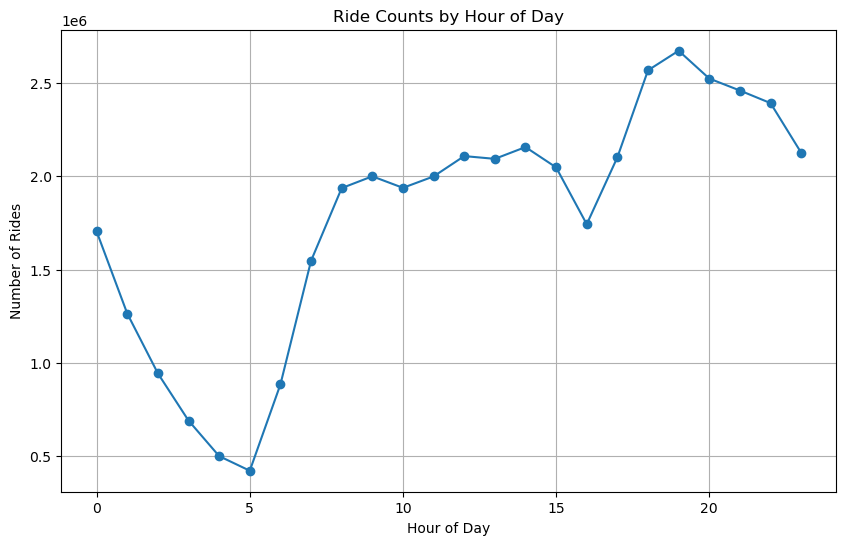

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hour_data['pickup_hour'], hour_data['count'], marker='o')
plt.title('Ride Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.show()

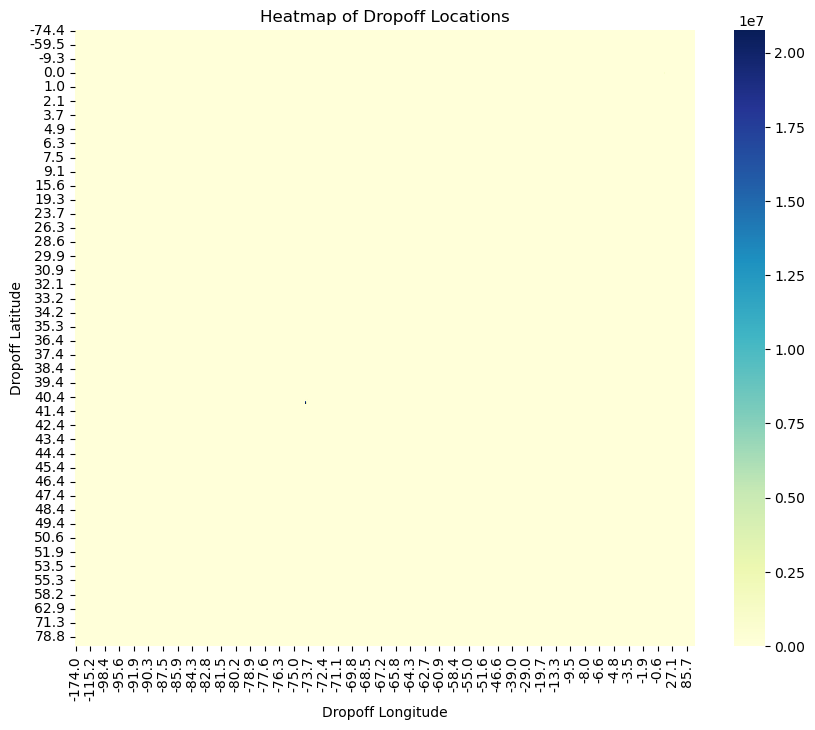

In [9]:
# Extract rounded latitude and longitude for heatmap aggregation
from pyspark.sql.functions import round
import seaborn as sns
df1 = df1.withColumn("dropoff_lat_round", round(df1.dropoff_latitude, 1))
df1 = df1.withColumn("dropoff_lon_round", round(df1.dropoff_longitude, 1))

# Aggregating locations
location_counts = df1.groupBy("dropoff_lat_round", "dropoff_lon_round").count().toPandas()

# Creating a pivot table for the heatmap using pivot_table instead of pivot
pivot_table = location_counts.pivot_table(index='dropoff_lat_round', columns='dropoff_lon_round', values='count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap="YlGnBu")
plt.title('Heatmap of Dropoff Locations')
plt.xlabel('Dropoff Longitude')
plt.ylabel('Dropoff Latitude')
plt.show()


# Map for drop and pickup location 

In [10]:
# Sample or aggregate data
sampled_df = df1.sample(fraction=0.001).select('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude').toPandas()

# Use folium to create a map
import folium

# Create a map centered around a common point, e.g., New York City
map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add sampled pickup and dropoff points to the map
for index, row in sampled_df.iterrows():
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=3,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        popup='Pickup'
    ).add_to(map)
    
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup='Dropoff'
    ).add_to(map)

# Save to an HTML file
map.save('taxi_rides_map.html')


In [11]:
# Save to a StringIO object
import io
output = io.BytesIO()
map.save(output, close_file=False)

# Upload to Google Cloud Storage
from google.cloud import storage

# Create a storage client
client = storage.Client()

# Reference an existing bucket
bucket = client.get_bucket('228bucket')

# Set the destination file name in bucket
blob = bucket.blob('taxi_rides_map.html')

# Upload the contents of the StringIO object
blob.upload_from_string(output.getvalue(), content_type='text/html')

# Important: Close the StringIO object
output.close()